In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier

In [18]:
df = pd.read_csv("credit_risk_dataset.csv")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [19]:
df.dropna(inplace=True)
print("After Dropping NA:", df.shape)


After Dropping NA: (28638, 12)


In [20]:
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

print("Encoded Data Sample")
print(df.head())

Encoded Data Sample
   person_age  person_income  person_home_ownership  person_emp_length  \
0          22          59000                      3              123.0   
1          21           9600                      2                5.0   
2          25           9600                      0                1.0   
3          23          65500                      3                4.0   
4          24          54400                      3                8.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_status  \
0            4           3      35000          16.02            1   
1            1           1       1000          11.14            0   
2            3           2       5500          12.87            1   
3            3           2      35000          15.23            1   
4            3           2      35000          14.27            1   

   loan_percent_income  cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                  

In [21]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)


Train Shape: (22910, 11)
Test Shape: (5728, 11)


In [24]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6382326721640295), 1: np.float64(2.3085449415558243)}


In [25]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight=class_weights),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight=class_weights),
    "SVM": SVC(kernel="rbf", probability=True, class_weight=class_weights, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight=class_weights),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=300, random_state=42, class_weight=class_weights)
}


In [32]:
results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = accuracy_score(y_test, y_pred)
    trained_models[name] = model

best_model_name = max(results, key=results.get)
best_model = trained_models[best_model_name]

print("Best Model:", best_model_name)


Best Model: Random Forest


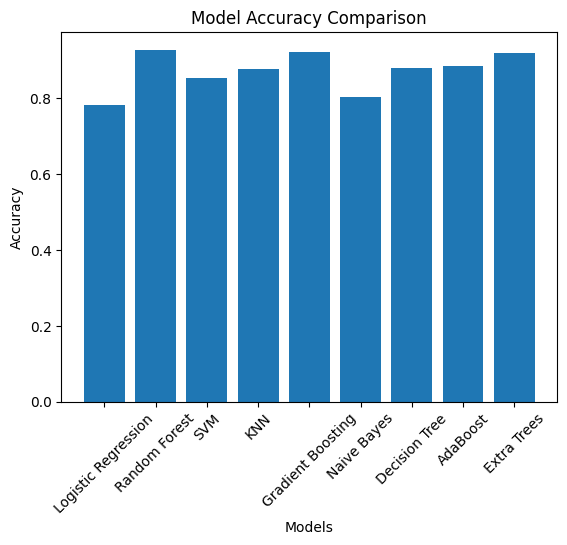

In [33]:
if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_data[name] = (fpr, tpr, auc(fpr, tpr))

plt.figure()
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

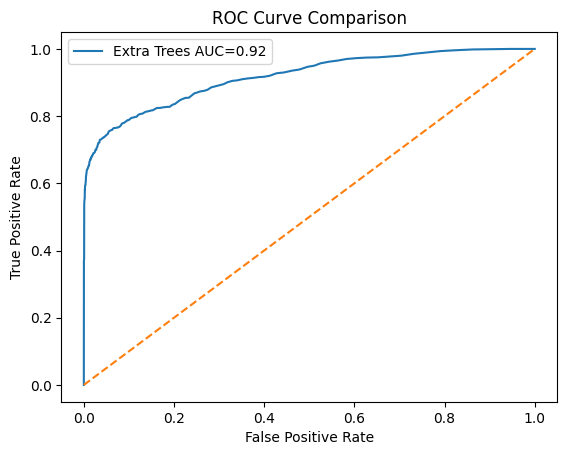

In [34]:
plt.figure()
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [37]:
y_best = best_model.predict(X_test)

print("\nBEST MODEL:", best_model_name)
print("Accuracy:", accuracy_score(y_test, y_best))
print(classification_report(y_test, y_best))


BEST MODEL: Random Forest
Accuracy: 0.927199720670391
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4487
           1       0.97      0.68      0.80      1241

    accuracy                           0.93      5728
   macro avg       0.95      0.84      0.88      5728
weighted avg       0.93      0.93      0.92      5728



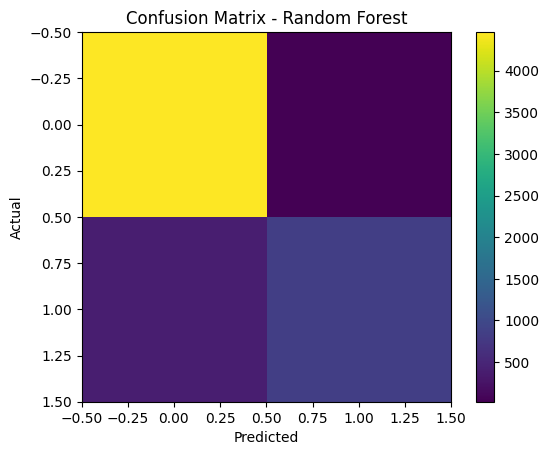

In [38]:
cm = confusion_matrix(y_test, y_best)
plt.figure()
plt.imshow(cm)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [39]:
if hasattr(best_model, "feature_importances_"):
    importance = best_model.feature_importances_
    features = df.drop("loan_status", axis=1).columns

    imp_df = pd.DataFrame({
        "Feature": features,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    print("\nFeature Importance")
    print(imp_df)


Feature Importance
                       Feature  Importance
8          loan_percent_income    0.209553
1                person_income    0.160951
7                loan_int_rate    0.144856
5                   loan_grade    0.120354
6                    loan_amnt    0.076957
2        person_home_ownership    0.068978
4                  loan_intent    0.062933
3            person_emp_length    0.055789
0                   person_age    0.047298
10  cb_person_cred_hist_length    0.038420
9    cb_person_default_on_file    0.013912


In [40]:
plt.figure()
plt.barh(imp_df["Feature"], imp_df["Importance"])    plt.gca().invert_yaxis()
    plt.title("Feature Importance")
    plt.show()

IndentationError: unexpected indent (1635295789.py, line 2)